In [22]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mrgabrielblins/speaker-recognition-cmu-arctic
import zipfile

with zipfile.ZipFile("speaker-recognition-cmu-arctic.zip", 'r') as zip_ref:
    zip_ref.extractall("speaker-recognition-cmu-arctic-data")

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/mrgabrielblins/speaker-recognition-cmu-arctic
License(s): CC0-1.0
speaker-recognition-cmu-arctic.zip: Skipping, found more recently modified local copy (use --force to force download)


# Imports

In [23]:
import torch
import torch.nn as nn
from torch.optim import Adam
import librosa
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Data

In [37]:
data_df = pd.read_csv('/content/speaker-recognition-cmu-arctic-data/test_full.csv')

data_df['file_path'] = '/content/speaker-recognition-cmu-arctic-data/' + data_df['file_path'].str[0:]

data_df.head()

,id,file_path,speech,speaker
0,OELV49874079341496,/content/speaker-recognition-cmu-arctic-data/t...,What was the object of your little sensation.,aew
1,ELDT67178766030957,/content/speaker-recognition-cmu-arctic-data/t...,He had no excuse for the feelings which were a...,eey
2,GWMS82652863581753,/content/speaker-recognition-cmu-arctic-data/t...,I'll see to poor Hughie.,awb
3,UAPD90278002373588,/content/speaker-recognition-cmu-arctic-data/t...,Then came my boy code.,jmk
4,IHIY50549582963537,/content/speaker-recognition-cmu-arctic-data/t...,We must give ourselves and not our money alone.,clb


In [38]:
# Drop unnecesary columns
data_df = data_df.drop(columns=['id', 'speech'], axis=1)
data_df.head()

,file_path,speaker
0,/content/speaker-recognition-cmu-arctic-data/t...,aew
1,/content/speaker-recognition-cmu-arctic-data/t...,eey
2,/content/speaker-recognition-cmu-arctic-data/t...,awb
3,/content/speaker-recognition-cmu-arctic-data/t...,jmk
4,/content/speaker-recognition-cmu-arctic-data/t...,clb


# Data investigation

Data Shape is:  (3117, 2)

Clases Distribution is: 


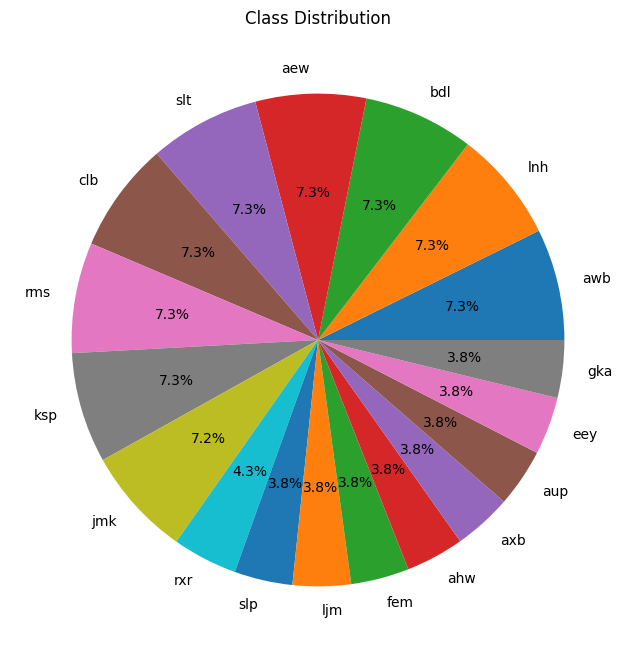

In [39]:
print('Data Shape is: ', data_df.shape)
print()

print('Clases Distribution is: ')
class_counts = data_df['speaker'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

# Data Split

In [40]:
label_encoder = LabelEncoder()
data_df['speaker'] = label_encoder.fit_transform(data_df['speaker'])

train = data_df.sample(frac=0.7, random_state=42)
test = data_df.drop(train.index)

val = test.sample(frac=0.5, random_state=42)
test = test.drop(val.index)

print("Training Shape: ", train.shape)
print("Validation Shape: ", val.shape)
print("Testing Shape: ", test.shape)

Training Shape:  (2182, 2)
Validation Shape:  (468, 2)
Testing Shape:  (467, 2)


# Custom Dataset Class

In [41]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.speakers = sorted(self.dataframe['speaker'].unique())
        self.speaker_to_idx = {spk: idx for idx, spk in enumerate(self.speakers)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        file_path = row['file_path']
        label = self.speaker_to_idx[row['speaker']]
        audio = torch.tensor(self.get_spectrogram(file_path), dtype=torch.float32).unsqueeze(0)
        return audio, torch.tensor(label, dtype=torch.long)

    def get_spectrogram(self, file_path):
        sr = 22050
        duration = 5
        img_height = 128
        img_width = 256

        signal, sr = librosa.load(file_path, sr=sr)

        # Pad or trim to 5 seconds
        target_length = sr * duration
        if len(signal) < target_length:
            signal = np.pad(signal, (0, target_length - len(signal)), mode='constant')
        else:
            signal = signal[:target_length]

        spec = librosa.feature.melspectrogram(
            y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128
        )
        spec_db = librosa.power_to_db(spec, ref=np.max)
        spec_resized = resize(spec_db, (img_height, img_width), anti_aliasing=True)
        return spec_resized


# Create Dataset Objects

In [42]:
train_dataset = CustomAudioDataset(dataframe=train)
val_dataset = CustomAudioDataset(dataframe=val)
test_dataset = CustomAudioDataset(dataframe=test)

# Hyperparameters

In [43]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

# DataLoaders

In [44]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [49]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(16)

    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(64)

    self.pooling = nn.MaxPool2d(2, 2)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.25)

    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear((64*16*32), 512)
    self.linear2 = nn.Linear(512, 256)
    self.linear3 = nn.Linear(256, 128)
    self.output = nn.Linear(128, len(data_df['speaker'].unique()))

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pooling(x)
    x = self.dropout(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pooling(x)
    x = self.dropout(x)

    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.pooling(x)
    x = self.dropout(x)

    x = self.flatten(x)
    x = self.linear1(x)
    x = self.dropout(x)
    x = self.linear2(x)
    x = self.dropout(x)
    x = self.linear3(x)
    x = self.dropout(x)
    x = self.output(x)

    return x

model = Net().to(device)

In [50]:
from torchsummary import summary
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
       BatchNorm2d-2         [-1, 16, 128, 256]              32
              ReLU-3         [-1, 16, 128, 256]               0
         MaxPool2d-4          [-1, 16, 64, 128]               0
           Dropout-5          [-1, 16, 64, 128]               0
            Conv2d-6          [-1, 32, 64, 128]           4,640
       BatchNorm2d-7          [-1, 32, 64, 128]              64
              ReLU-8          [-1, 32, 64, 128]               0
         MaxPool2d-9           [-1, 32, 32, 64]               0
          Dropout-10           [-1, 32, 32, 64]               0
           Conv2d-11           [-1, 64, 32, 64]          18,496
      BatchNorm2d-12           [-1, 64, 32, 64]             128
             ReLU-13           [-1, 64, 32, 64]               0
        MaxPool2d-14           [-1, 64,

# Loss and Optimizer

In [51]:
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

# Training

In [52]:
total_loss_train_plot = [] # Empty list to be filled with train loss after each epoch
total_loss_validation_plot = [] # Empty list to be filled with validation loss after each epoch
total_acc_train_plot = [] # Empty list to be filled with train accuracy after each epoch
total_acc_validation_plot = [] # Empty list to be filled with validation accuracy after each epoch

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()
      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}%''')
  print("="*60)

Epoch 1/25, Train Loss: 3.77 Train Accuracy 23.0064%
              Validation Loss: 0.6509 Validation Accuracy: 36.7521%
Epoch 2/25, Train Loss: 2.0741 Train Accuracy 52.6123%
              Validation Loss: 0.3695 Validation Accuracy: 61.7521%
Epoch 3/25, Train Loss: 1.2152 Train Accuracy 69.9817%
              Validation Loss: 0.2426 Validation Accuracy: 73.0769%
Epoch 4/25, Train Loss: 0.7799 Train Accuracy 80.8891%
              Validation Loss: 0.2138 Validation Accuracy: 75.4274%
Epoch 5/25, Train Loss: 0.5558 Train Accuracy 86.8011%
              Validation Loss: 0.155 Validation Accuracy: 81.6239%
Epoch 6/25, Train Loss: 0.3243 Train Accuracy 92.3923%
              Validation Loss: 0.1255 Validation Accuracy: 86.3248%
Epoch 7/25, Train Loss: 0.2479 Train Accuracy 94.1797%
              Validation Loss: 0.106 Validation Accuracy: 88.4615%
Epoch 8/25, Train Loss: 0.2613 Train Accuracy 93.8588%
              Validation Loss: 0.1139 Validation Accuracy: 88.0342%
Epoch 9/25, Train Lo

# Testing

In [56]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    predictions = model(inputs)

    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()
    test_acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += test_acc
print(f'Loss Score is: {round(total_loss_test/1000, 4)} and Accuracy is: {round(total_acc_test/test_dataset.__len__()*100, 4)}')

Loss Score is: 0.0041 and Accuracy is: 97.0021


# Plotting Training Progress

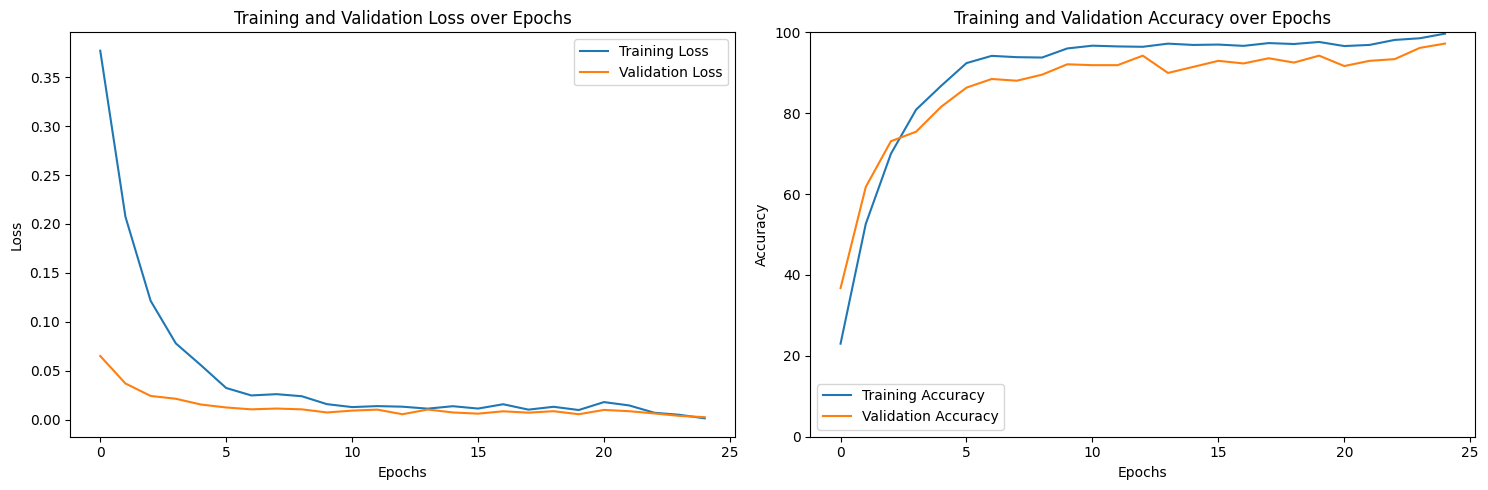

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()